## Importing necessary packages

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
import sys
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

## Loading the CSV file

In [2]:
NYPD_raw = pd.read_csv('NYPD_Shooting_Incident_Data__Historic_.csv')[["OCCUR_TIME", "BORO", "PERP_AGE_GROUP","PERP_SEX", "PERP_RACE","STATISTICAL_MURDER_FLAG", "Latitude", "Longitude"]]

## Feature selection and Feature Pre-processing

In [3]:
#rename columns
NYPD_raw = NYPD_raw.rename(columns={"OCCUR_TIME": "Time", "BORO": "Location", "PERP_AGE_GROUP":"Age_group", "PERP_SEX": "Sex", "PERP_RACE": "Race", "STATISTICAL_MURDER_FLAG": "Is.Murder"})
# remove NAs
NYPD_raw.dropna(inplace=True)
NYPD1 = NYPD_raw.reset_index(drop=True)

In [4]:
# Remove nonsensical rows from Age_Group column
NYPD1 = NYPD1[(NYPD1["Age_group"] != "1020") & (NYPD1["Age_group"] != "940") & (NYPD1["Age_group"] != "224")]

In [5]:
# reference: https://stackoverflow.com/questions/37801321/python-pandas-convert-string-to-time-only
NYPD1["Time"] = pd.to_datetime(NYPD1["Time"], format='%H:%M:%S').dt.time
NYPD1["Hour"] = pd.to_datetime(NYPD1["Time"], format='%H:%M:%S').dt.hour

In [6]:
# reference: https://stackoverflow.com/questions/55571311/get-part-of-day-morning-afternoon-evening-night-in-python-dataframe
# Categorizing the time of day
b = [0,6,18,22]
l = ["Sleeping hours", "Working hours","Afterwork"]
NYPD1["Period"] = pd.cut(NYPD1["Hour"], bins=b, labels=l)
NYPD_clean = NYPD1.replace(np.nan, "Sleeping hours", regex=True)

In [7]:
NYPD_clean.head()

,Time,Location,Age_group,Sex,Race,Is.Murder,Latitude,Longitude,Hour,Period
0,15:20:00,BROOKLYN,18-24,M,BLACK,False,40.639137,-73.951236,15,Working hours
1,20:58:00,BROOKLYN,25-44,M,BLACK,False,40.650929,-73.930297,20,Afterwork
2,19:03:00,BROOKLYN,25-44,M,BLACK,True,40.674459,-73.938910,19,Afterwork
3,11:54:00,BROOKLYN,<18,M,WHITE HISPANIC,False,40.626383,-73.961621,11,Working hours
4,03:55:00,MANHATTAN,25-44,M,BLACK,False,40.754916,-73.972476,3,Sleeping hours


### Heatmap

In [8]:
# reference: https://eatsleepdata.com/how-to-generate-a-geographical-heatmap-with-python
import gmplot

# Store our latitude and longitude
latitudes = NYPD_clean["Latitude"]
longitudes = NYPD_clean["Longitude"]


# Creating the location we would like to initialize the focus on. 
# Parameters: Latitude, Longitude, Zoom
gmap = gmplot.GoogleMapPlotter(40.626383, -73.961621, 10)

# Overlay our datapoints onto the map
gmap.heatmap(latitudes, longitudes)

# Generate the heatmap into an HTML file
gmap.draw("my_heatmap.html")

### Data Visualization of all Crime
#### Without removing unknown values

#### Is.Murder group graph

Text(0, 0.5, '')

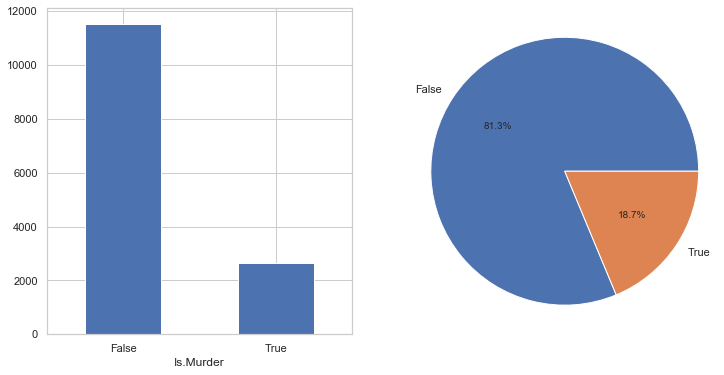

In [9]:
# Is.Murder group graph
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
murder_group = NYPD_clean.groupby("Is.Murder")
murder_group.size().plot(kind='bar')
plt.xticks(rotation=0)
plt.subplot(1, 2, 2)
murder_group.size().plot(kind='pie', autopct='%.1f%%', radius = 1.1)
plt.ylabel('')

#### Sex group

Text(0, 0.5, '')

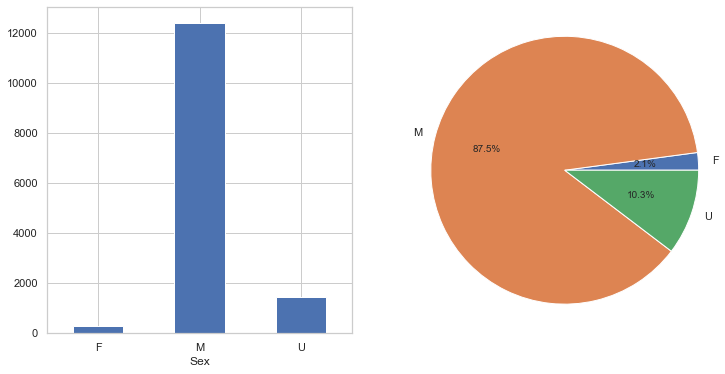

In [10]:
# Sex group graph
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sex_group = NYPD_clean.groupby("Sex")
sex_group.size().plot(kind='bar')
plt.xticks(rotation=0)
plt.subplot(1, 2, 2)
sex_group.size().plot(kind='pie', autopct='%.1f%%', radius = 1.1)
plt.ylabel('')

#### Race group

Text(0, 0.5, '')

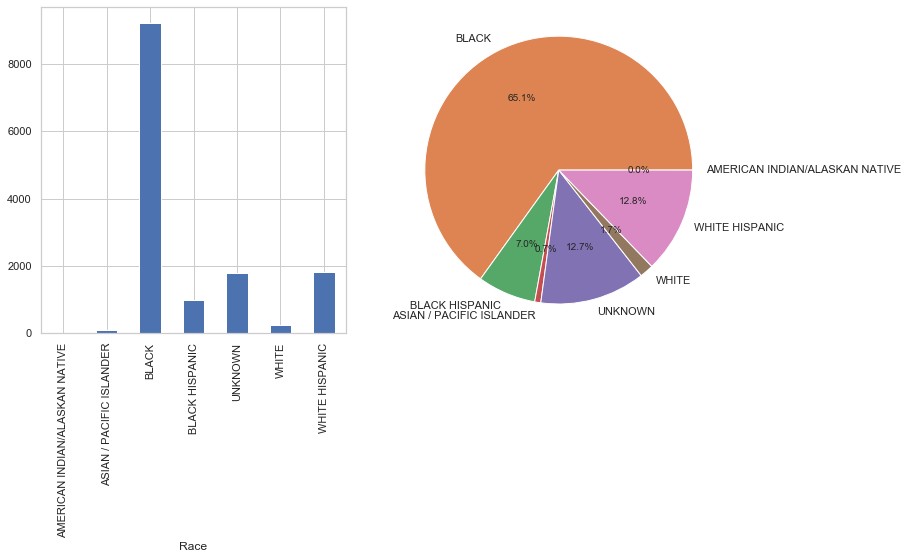

In [11]:
# reference: https://stackoverflow.com/questions/30009948/how-to-reorder-indexed-rows-based-on-a-list-in-pandas-data-frame
# Race graph
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
race_group = NYPD_clean.groupby("Race")
race_group.size().plot(kind='bar')
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
race_group.size().reindex(['AMERICAN INDIAN/ALASKAN NATIVE', 'BLACK',
       'BLACK HISPANIC', 'ASIAN / PACIFIC ISLANDER','UNKNOWN','WHITE', 'WHITE HISPANIC']).plot(kind='pie', autopct='%.1f%%', radius = 1.1)
plt.xticks(rotation=90)
plt.ylabel('')

In [12]:
race_group.size()

Race
AMERICAN INDIAN/ALASKAN NATIVE       2
ASIAN / PACIFIC ISLANDER           104
BLACK                             9231
BLACK HISPANIC                     999
UNKNOWN                           1802
WHITE                              238
WHITE HISPANIC                    1811
dtype: int64

#### Age group

Text(0, 0.5, '')

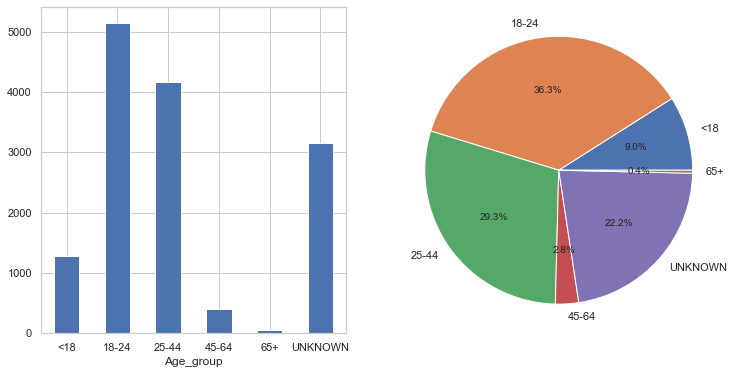

In [13]:
# reference: https://stackoverflow.com/questions/30009948/how-to-reorder-indexed-rows-based-on-a-list-in-pandas-data-frame
# Age_group graph
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
Age_group = NYPD_clean.groupby("Age_group")
Age_group.size().reindex(["<18", "18-24", "25-44", "45-64", "65+", "UNKNOWN"]).plot(kind='bar')
plt.xticks(rotation=0)
plt.subplot(1, 2, 2)
Age_group.size().reindex(["<18", "18-24", "25-44", "45-64", "UNKNOWN", "65+"]).plot(kind='pie', autopct='%.1f%%', radius = 1.1)
plt.ylabel('')

#### Location group

Text(0, 0.5, '')

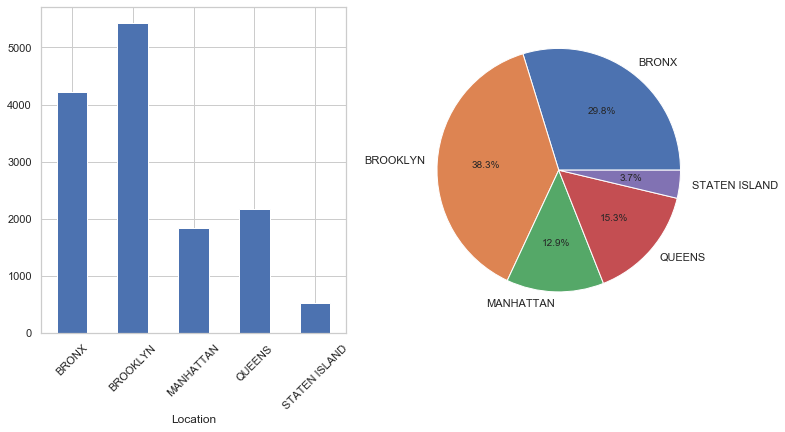

In [14]:
# reference: https://stackoverflow.com/questions/30009948/how-to-reorder-indexed-rows-based-on-a-list-in-pandas-data-frame
# location_group graph
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
location_group = NYPD_clean.groupby("Location")
location_group.size().plot(kind='bar')
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
location_group.size().plot(kind='pie', autopct='%.1f%%')
plt.ylabel('')

#### Time period group

Text(0, 0.5, '')

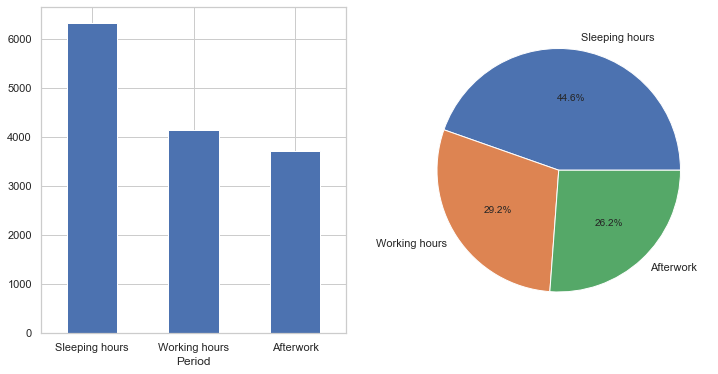

In [15]:
# time_period graph
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
location_group = NYPD_clean.groupby("Period")
location_group.size().plot(kind='bar')
plt.xticks(rotation=0)
plt.subplot(1, 2, 2)
location_group.size().plot(kind='pie', autopct='%.1f%%')
plt.ylabel('')

## Further cleaning data

In [16]:
# Remove AMERICAN INDIAN/ALASKAN NATIVE group from dataset because it only has 2 observations
NYPD_clean1 = NYPD_clean[NYPD_clean["Race"] != "AMERICAN INDIAN/ALASKAN NATIVE"]

In [17]:
NYPD_clean1.head()

,Time,Location,Age_group,Sex,Race,Is.Murder,Latitude,Longitude,Hour,Period
0,15:20:00,BROOKLYN,18-24,M,BLACK,False,40.639137,-73.951236,15,Working hours
1,20:58:00,BROOKLYN,25-44,M,BLACK,False,40.650929,-73.930297,20,Afterwork
2,19:03:00,BROOKLYN,25-44,M,BLACK,True,40.674459,-73.938910,19,Afterwork
3,11:54:00,BROOKLYN,<18,M,WHITE HISPANIC,False,40.626383,-73.961621,11,Working hours
4,03:55:00,MANHATTAN,25-44,M,BLACK,False,40.754916,-73.972476,3,Sleeping hours


Text(0, 0.5, '')

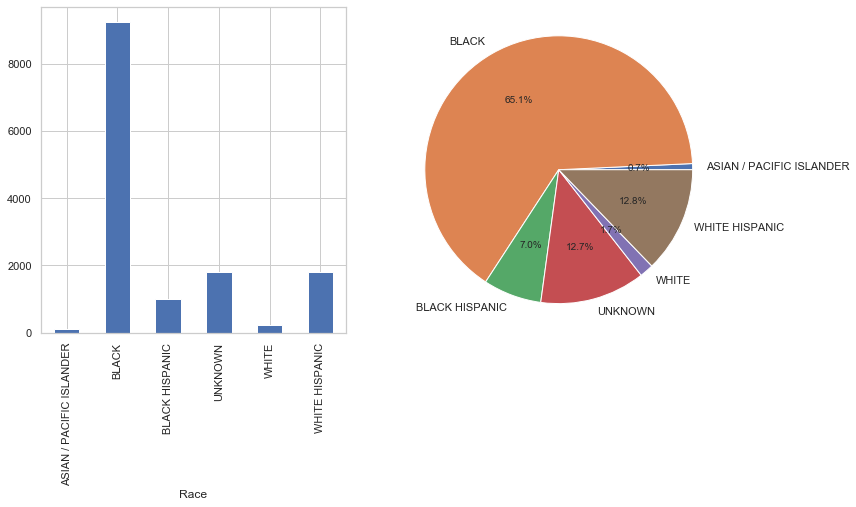

In [18]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
race_group = NYPD_clean1.groupby("Race")
race_group.size().plot(kind='bar')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
race_group.size().plot(kind='pie', autopct='%.1f%%', radius = 1.1)
plt.xticks(rotation=90)
plt.ylabel('')


In [19]:
v1 = NYPD_clean1["Race"].replace("UNKNOWN","Unknown_Race").copy()
v2 = NYPD_clean1["Age_group"].replace("UNKNOWN","Unknown_Age").copy()
v3 = NYPD_clean1["Sex"].replace("U","Unknown_Sex").copy()


NYPD_clean1 = NYPD_clean1.drop(columns = ["Race","Age_group", "Sex"])
NYPD_clean1["Race"] = v1
NYPD_clean1["Age_group"] = v2
NYPD_clean1["Sex"] = v3

In [20]:
NYPD_clean1.shape

(14185, 10)

### Data Visualization after removing unknowns
#### All Crime vs. Murder-Involved Crime

In [21]:
## Dataset where murder happened
Murder_True = NYPD_clean1[NYPD_clean1["Is.Murder"] == True]

In [22]:
### polt function
def plot_helper(df1, df2, col):
    plt.figure(figsize=(14,10))
    plt.subplot(2,2,1)

    ## bar plot for sex group for all crimes
    df1.size().plot(kind='bar')
    plt.xticks(rotation=0)
    plt.title("Frequency of each "+ col+ " group for all crimes")

    # pie chart for sex group for all crimes
    plt.subplot(2, 2, 2)
    df1.size().plot(kind='pie', autopct='%.1f%%', radius = 1.1)
    plt.ylabel('')
    plt.title("Percentage of each "+ col+ " group for all crimes")


    # bar plot for sex group where murder happened
    plt.subplot(2, 2, 3)
    df2.size().plot(kind='bar')
    plt.xticks(rotation=0)
    plt.title("Frequency of each "+ col+ " group for murders")


    # pie chart for sex group where murder happened
    plt.subplot(2, 2, 4)
    df2.size().plot(kind='pie', autopct='%.1f%%', radius = 1.1)
    plt.ylabel('')
    plt.title("Percentage of each "+ col+ " group for murders")

#### Sex group

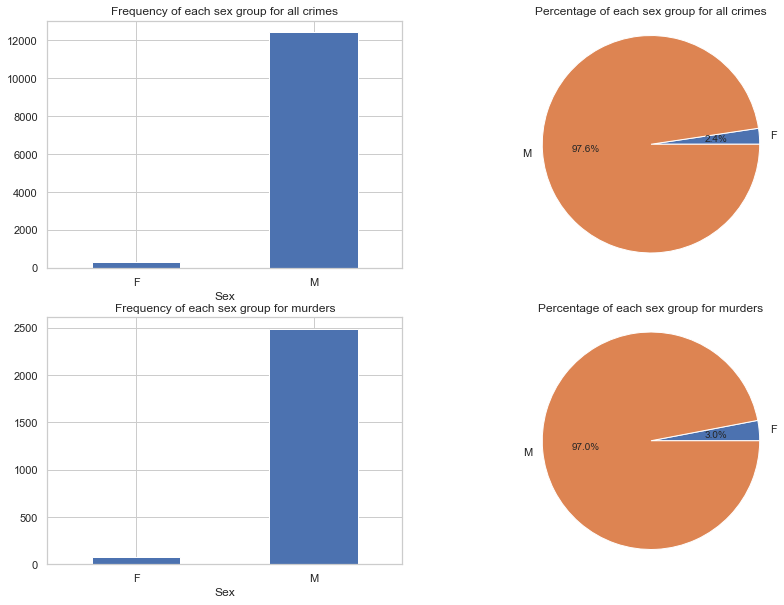

In [23]:
## Remove Unknown from Sex group
sex = NYPD_clean1[NYPD_clean1["Sex"] != "Unknown_Sex"]
sex_murder = Murder_True[Murder_True["Sex"] != "Unknown_Sex"]

sex1 = sex.groupby("Sex")
sex_murder1 = sex_murder.groupby("Sex")

plot_helper(sex1, sex_murder1, "sex")

#### Race group

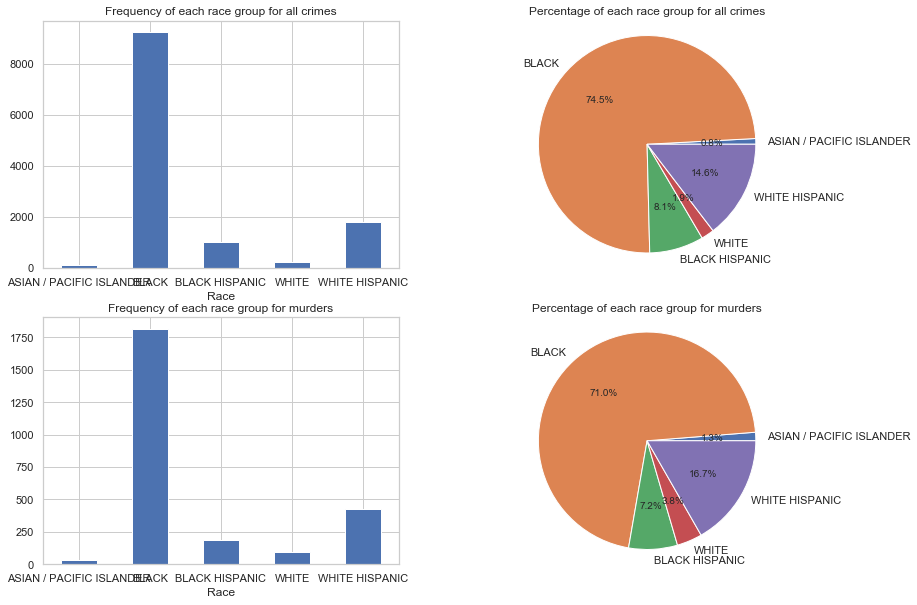

In [24]:
## Remove Unknown from Race group
race = NYPD_clean1[NYPD_clean1["Race"] != "Unknown_Race"]
race_murder = Murder_True[Murder_True["Race"] != "Unknown_Race"]

race1 = race.groupby("Race")
race_murder1 = race_murder.groupby("Race")

plot_helper(race1, race_murder1, "race")

#### Age group 

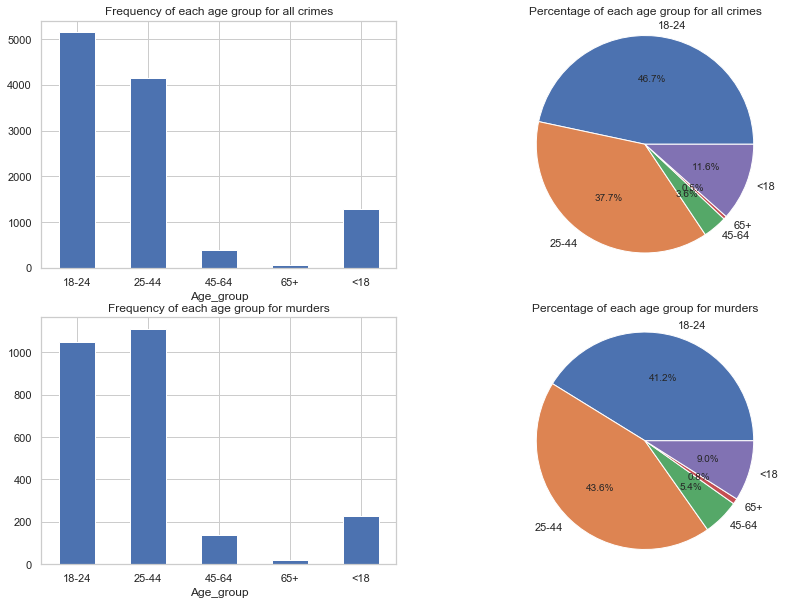

In [25]:
## Remove Unknown from Age group
age = NYPD_clean1[NYPD_clean1["Age_group"] != "Unknown_Age"]
age_murder = Murder_True[Murder_True["Age_group"] != "Unknown_Age"]

age1 = age.groupby("Age_group")
age_murder1 = age_murder.groupby("Age_group")

plot_helper(age1, age_murder1, "age")

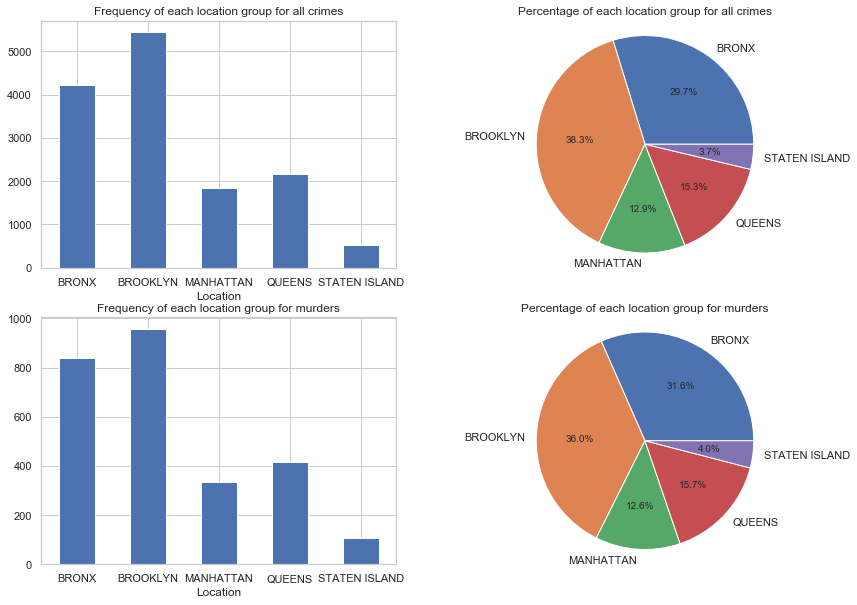

In [77]:
# plots for location
loc = NYPD_clean1.groupby("Location")
loc_murder = Murder_True.groupby("Location")

plot_helper(loc, loc_murder, "location")

#### Period Time

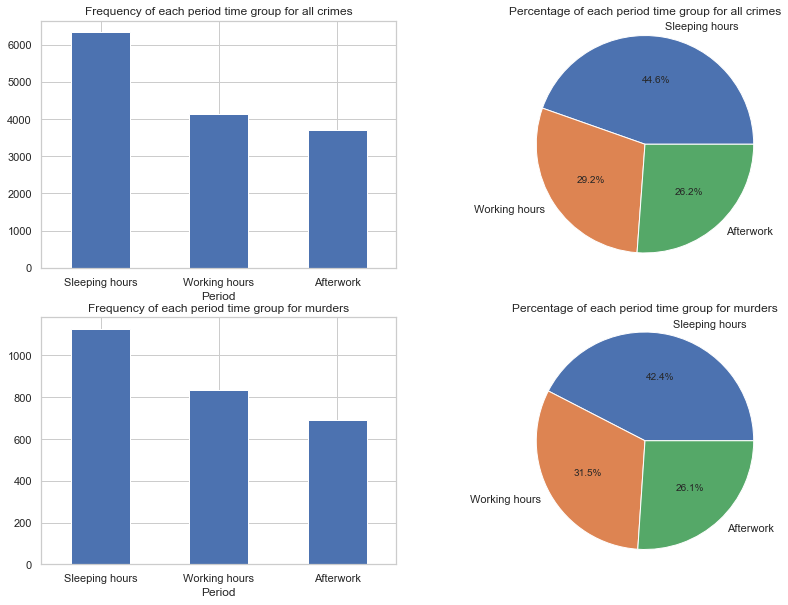

In [27]:
# plots for location
time = NYPD_clean1.groupby("Period")
time_murder = Murder_True.groupby("Period")

plot_helper(time, time_murder, "period time")

### Model Selection

In [28]:
X = NYPD_clean1.drop(columns=["Is.Murder", "Time", "Hour", "Latitude", "Longitude"])
y = NYPD_clean1[["Is.Murder"]]

In [29]:
# Using one-hot encoding to change category variables to indicators
ohe1 = OneHotEncoder(sparse=False, dtype=int)
ohe2 = OneHotEncoder(sparse=False, dtype=int)
data = ohe1.fit_transform(X[["Location", "Age_group", "Sex", "Race", "Period"]])
# response = ohe2.fit_transform(y[["Is.Murder"]])

In [30]:
columns = []
for i in range(5):
    columns.extend(ohe1.categories_[i])

In [31]:
X1 = pd.DataFrame(data, columns= columns)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X1,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=123)

In [33]:
pipe = Pipeline([('classifier', LogisticRegression(solver='lbfgs'))])

In [34]:
# model selection through pipelining
search_space = [{'classifier': [LogisticRegression(solver='lbfgs')], # within the logistic model, we want to change C
                 'classifier__C': [0.01, 0.1, 1.0]},
                {'classifier': [MultinomialNB()], # we want to change hyperparameter alpha in MultinomialNB
                 'classifier__alpha': [0.01, 0.1, 1, 10]},
               {'classifier':[RandomForestClassifier(max_depth = None)],
                'classifier__n_estimators':[50, 100, 150, 200]}]

In [35]:
clf = GridSearchCV(pipe, search_space, cv=10, verbose=0)

In [36]:
best_model = clf.fit(X_train, y_train)

In [37]:
best_model.best_estimator_.get_params()['classifier']

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
y_train1 = y_train.reset_index()
X_train1 = X_train.reset_index()
training_dataset= pd.merge(X_train1, y_train1, left_index=True, right_index = True)
training_dataset = training_dataset.drop(columns = ["index_x", "index_y"])

In [39]:
training_dataset.shape

(11348, 24)

In [40]:
training_dataset.isnull().values.any()

False

### Define a new function to create model
#### Get train error and validation error

In [41]:
def validation(X_train, y_train):
    model = LogisticRegression(C=0.01)
    cv_score = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
    print(f"The mean training error is: {1 - cv_score['train_score'].mean():.5f}")
    print(f"The mean cross-validation error is: {1 - cv_score['test_score'].mean():.5f}")
    return model.fit(X_train, y_train)

### Logistic Model -- Full Model

In [42]:
full_model = validation(X_train, y_train)

The mean training error is: 0.18638
The mean cross-validation error is: 0.18638


### Create one model for each race groups

In [43]:
Asian = training_dataset[training_dataset["ASIAN / PACIFIC ISLANDER"] == 1]
Black = training_dataset[training_dataset["BLACK"] == 1]
Black_Hispanic = training_dataset[training_dataset["BLACK HISPANIC"] == 1]
White = training_dataset[training_dataset["WHITE"] == 1 ] 
White_Hispanic = training_dataset[training_dataset["WHITE HISPANIC"] == 1]
Unknown = training_dataset[training_dataset["Unknown_Race"] == 1] 

In [44]:
Asian.shape

(89, 24)

In [45]:
asian_X_train = Asian.drop(columns = "Is.Murder")
asian_y_train = Asian[["Is.Murder"]]
asian_model = validation(asian_X_train, asian_y_train)

The mean training error is: 0.31459
The mean cross-validation error is: 0.31333


In [46]:
black_X_train = Black.drop(columns = "Is.Murder")
black_y_train = Black[["Is.Murder"]]
black_model = validation(black_X_train, black_y_train)

The mean training error is: 0.19591
The mean cross-validation error is: 0.19591


In [47]:
black_hispanic_X_train = Black_Hispanic.drop(columns = "Is.Murder")
black_hispanic_y_train = Black_Hispanic[["Is.Murder"]]
black_hispanic_model = validation(black_hispanic_X_train, black_hispanic_y_train)

The mean training error is: 0.17896
The mean cross-validation error is: 0.17894


In [48]:
white_X_train = White.drop(columns = "Is.Murder")
white_y_train = White[["Is.Murder"]]
white_model = validation(white_X_train, white_y_train)

The mean training error is: 0.37368
The mean cross-validation error is: 0.37363


In [49]:
white_hispanic_X_train = White_Hispanic.drop(columns = "Is.Murder")
white_hispanic_y_train = White_Hispanic[["Is.Murder"]]
white_hispanic_model = validation(white_hispanic_X_train, white_hispanic_y_train)

The mean training error is: 0.23570
The mean cross-validation error is: 0.23570


In [50]:
unknown_X_train = Unknown.drop(columns = "Is.Murder")
unknown_y_train = Unknown[["Is.Murder"]]
unknown_model = validation(unknown_X_train, unknown_y_train)

The mean training error is: 0.05936
The mean cross-validation error is: 0.05934


### An alternative way to build model
#### one model for Black, one model for the rest race groups

In [51]:
Black = training_dataset[training_dataset["BLACK"] == 1]
rest = training_dataset[training_dataset["BLACK"] != 1]

In [52]:
# model for the rest
black_X_train1 = Black.drop(columns = "Is.Murder")
black_y_train1 = Black[["Is.Murder"]]
black_model1 = validation(black_X_train1, black_y_train1)

The mean training error is: 0.19591
The mean cross-validation error is: 0.19591


In [53]:
# model for the rest
rest_X_train = rest.drop(columns = "Is.Murder")
rest_y_train = rest[["Is.Murder"]]
rest_model = validation(rest_X_train, rest_y_train)

The mean training error is: 0.16868
The mean cross-validation error is: 0.16868


### Randomly select 89 observations (same as the # of observations from the smallest race group) from each group and create a single model

In [54]:
Black_subset = Black.sample(n=89)
Black_Hispanic_subset = Black_Hispanic.sample(n=89)
White_subset = White.sample(n=89)
White_Hispanic_subset = White_Hispanic.sample(n=89)
Unknown_subset = Unknown.sample(n=89)

In [55]:
Asian.shape

(89, 24)

In [56]:
total_subset = Asian.append(Black_subset)
total_subset = total_subset.append(Black_Hispanic_subset)
total_subset = total_subset.append(White_subset)
total_subset = total_subset.append(White_Hispanic_subset)
total_subset = total_subset.append(Unknown_subset)
total_subset.shape

(534, 24)

In [57]:
total_subset_X_train = total_subset.drop(columns = "Is.Murder")
total_subset_y_train = total_subset[["Is.Murder"]]
subset_model = validation(total_subset_X_train, total_subset_y_train)

The mean training error is: 0.21348
The mean cross-validation error is: 0.21342


### Choose Final Model
#### We choose the third option: create one model for Black and one for the rest race groups

In [58]:
y_test1 = y_test.reset_index()
X_test1 = X_test.reset_index()
testing_dataset= pd.merge(X_test1, y_test1, left_index=True, right_index = True)
testing_dataset = testing_dataset.drop(columns = ["index_x", "index_y"])

In [59]:
testing_dataset.shape

(2837, 24)

In [60]:
black_test = testing_dataset[testing_dataset["BLACK"] == 1]
rest_test = testing_dataset[testing_dataset["BLACK"] != 1]

In [61]:
black_X_test = black_test.drop(columns = "Is.Murder")
black_y_test = black_test[["Is.Murder"]]

In [62]:
rest_X_test = rest_test.drop(columns = "Is.Murder")
rest_y_test = rest_test[["Is.Murder"]]

### Black Model1 - Test error rate and feature importance

In [63]:
# test error for black_model1
print(f"test error = {1 - black_model1.score(black_X_test, black_y_test):.10f}")
black_result = pd.DataFrame(black_model1.predict_proba(black_X_train1), columns = ["False", "True"])
pd.DataFrame({'names': testing_dataset.columns[:-1],
              'coefs': black_model1.coef_[0]}).sort_values(by='coefs', ascending = False)

test error = 0.1983827493


,names,coefs
6,25-44,0.331989
7,45-64,0.143514
8,65+,0.024570
5,18-24,0.011831
19,WHITE HISPANIC,0.000000
18,WHITE,0.000000
17,Unknown_Race,0.000000
16,BLACK HISPANIC,0.000000
14,ASIAN / PACIFIC ISLANDER,0.000000
0,BRONX,-0.000957


### Rest (Non-black) Model1 - Test error rate and feature importance

In [64]:
# test error for rest_model
print(f"test error = {1 - rest_model.score(rest_X_test, rest_y_test):.10f}")
rest_result = pd.DataFrame(rest_model.predict_proba(rest_X_train), columns = ["False", "True"])
pd.DataFrame({'names': testing_dataset.columns[:-1],
              'coefs': rest_model.coef_[0]}).sort_values(by='coefs', ascending = False)

test error = 0.1761710794


,names,coefs
7,45-64,0.162451
18,WHITE,0.139982
6,25-44,0.109384
14,ASIAN / PACIFIC ISLANDER,0.048800
8,65+,0.015837
15,BLACK,0.000000
4,STATEN ISLAND,-0.002916
22,Working hours,-0.025218
19,WHITE HISPANIC,-0.032346
11,F,-0.040076


### Set cutoff point and find out how many officers we need to send

In [65]:
# <60%: send 2 
# 60%-85%: send 4
# 85%-95%: send 8
# >95%: swat team
def set_cutoff(df):
    # reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.quantile.html
    df1 = df.sort_values(by=["True"])[["True"]]
    # set the cutoff by percentile, this can be changed later
    result = df1.quantile([0.6, 0.85, 0.95])
    return result

In [66]:
# black group probabilities
black_cut_off = set_cutoff(black_result)
black_cut_off

,True
0.60,0.213138
0.85,0.250857
0.95,0.271712


In [67]:
# rest group probabilities
rest_cut_off = set_cutoff(rest_result)
rest_cut_off

,True
0.60,0.217400
0.85,0.262315
0.95,0.298171


### Sample test data

In [68]:
col = X1.columns
new_data_Frame = pd.DataFrame(columns=col)

In [69]:
# F, M, Unknown_Sex
gender = input("Enter a gender: ")

Enter a gender: M


In [70]:
# 'ASIAN / PACIFIC ISLANDER', 'BLACK', 'BLACK HISPANIC', 'Unknown_Race','WHITE', 'WHITE HISPANIC'
race = input("Enter race group: ")

Enter race group: BLACK


In [71]:
# 'BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND'
location = input("Enter location: ")

Enter location: QUEENS


In [72]:
# 18-24', '25-44', '45-64', '65+', '<18', 'Unknown_Age'
age = input("Enter age group: ")

Enter age group: 65+


In [73]:
# 'Afterwork', 'Sleeping hours', 'Working hours'
time = input("Enter time period: ")

Enter time period: Working hours


In [74]:
test_data = {"Location": location, 
                         "Age_group": age,
                         "Sex": gender,
                         "Race": race,
                         "Period": time}

In [75]:
s=pd.Series(test_data)
test_dataframe = new_data_Frame.append(s[new_data_Frame.columns], ignore_index=True).fillna(0)
for i in test_data.values():
    test_dataframe[i] = 1
test_dataframe.columns

Index(['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND', '18-24',
       '25-44', '45-64', '65+', '<18', 'Unknown_Age', 'F', 'M', 'Unknown_Sex',
       'ASIAN / PACIFIC ISLANDER', 'BLACK', 'BLACK HISPANIC', 'Unknown_Race',
       'WHITE', 'WHITE HISPANIC', 'Afterwork', 'Sleeping hours',
       'Working hours'],
      dtype='object')

In [76]:
print("The suspect is "+gender +" "+race+" in "+location+' during time period of '+time+" with age about: "+age)
if (test_data["Race"] == "BLACK"):
    true_prob = black_model1.predict_proba(test_dataframe)[0][1]
    print(f"The probablity of murder is : {true_prob:.2f}")
    if (true_prob < black_cut_off.iloc[0][0]):
        print("The threat level is Low. We should send 2 people.")
    elif (true_prob < black_cut_off.iloc[1][0]):
        print("The threat level is Medium. We should send 4 people.")
    elif (true_prob < black_cut_off.iloc[2][0]):
        print("The threat level is High. We should send 8 people.")
    else:
        print("The threat level is extremely High. We should send SWAT team.")
        
else:
    true_prob = rest_model.predict_proba(test_dataframe)[0][1]
    print(f"The probablity of murder is : {true_prob:.2f}")
    if (true_prob < rest_cut_off.iloc[0][0]):
        print("The threat level is Low. We should send 2 people.")
    elif (true_prob < rest_cut_off.iloc[1][0]):
        print("The threat level is Medium. We should send 4 people.")
    elif (true_prob < rest_cut_off.iloc[2][0]):
        print("The threat level is High. We should send 8 people.")
    else:
        print("The threat level is extremely High. We should send SWAT team.")

The suspect is M BLACK in QUEENS during time period of Working hours with age about: 65+
The probablity of murder is : 0.19
The threat level is Low. We should send 2 people.
